1. MA ppln creates locality-sensitive signature of input temporal pattern. Some patterns more distinguishable than others. Emerges from integration of nonlinearly "twisted" representation of input. Can typically find multiple distinguishable patterns simply by sampling natural song snippets.

2. This suggests possibility for tracking multiple novel evidence streams, presented as temporally interleaved or potentially superimposed input patterns. This is because each of a small set of input patterns will generally push the neural state in a reliable unique direction every time that input is presented. Note we expect short-term history modulation of this effect, e.g. if the pause between inputs is less than nonlinearity timescale then second presentation will yield different integral.

3. We tested this by presenting sequences of interleaved song snippets, each corresponding to a different "word", and measuring the ability of a linear decoder to read out the accumulated count of each word as the sequence is presented, which despite its simplicity can carry a substantial amount of semantic information. Vary word length, pause duration, number of unique words, ppln size.

# Exploration of the MA ppln code as a generic pattern-accumulating reservoir

$$\tau_r^i \frac{dr^i}{dt} = -r^i + u^i(t)$$

$$u^i = x_s^i(1 - a_s^i)I_s(t) + x_p^i(1 - a_p^i)I_p(t)$$

$$\tau_a^i \frac{da_s^i}{dt} = -a_s^i + I_s(t)$$

$$\tau_a^i \frac{da_p^i}{dt} = -a_p^i + I_s(t)$$

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
from aux import get_seg
# get snippets
NT_SNP = int(round(2*FPS))
t_snp = np.arange(NT_SNP)*DT

nsnp_max = np.inf #100

min_gap = int(round(3*FPS))
min_frac_sing = 0

snps = []

for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:NT_SNP] for seg in segs if (len(seg) >= NT_SNP) and (np.mean(seg > 0) > min_frac_sing)]
    snps.extend(segs)
    
    if len(snps) > nsnp_max:
        break
    
snps = np.array(snps)
nsnp = len(snps)

i_ss = [(snp == 1).astype(float) for snp in snps]
i_ps = [(snp == 2).astype(float) for snp in snps]

print(f'{nsnp} snippets')

2237 snippets


In [5]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)
# minh = np.random.rand(N) < .5
# x_s[minh] *= -1
# x_p[minh] *= -1

In [6]:
def smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, dt):
    t = np.arange(len(i_s))*dt
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integral
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        da_s = (dt/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ss[ct, :] = a_ss[ct-1, :] + da_s
        
        da_p = (dt/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + da_p
        
    return rs, vs, a_ss, a_ps, t

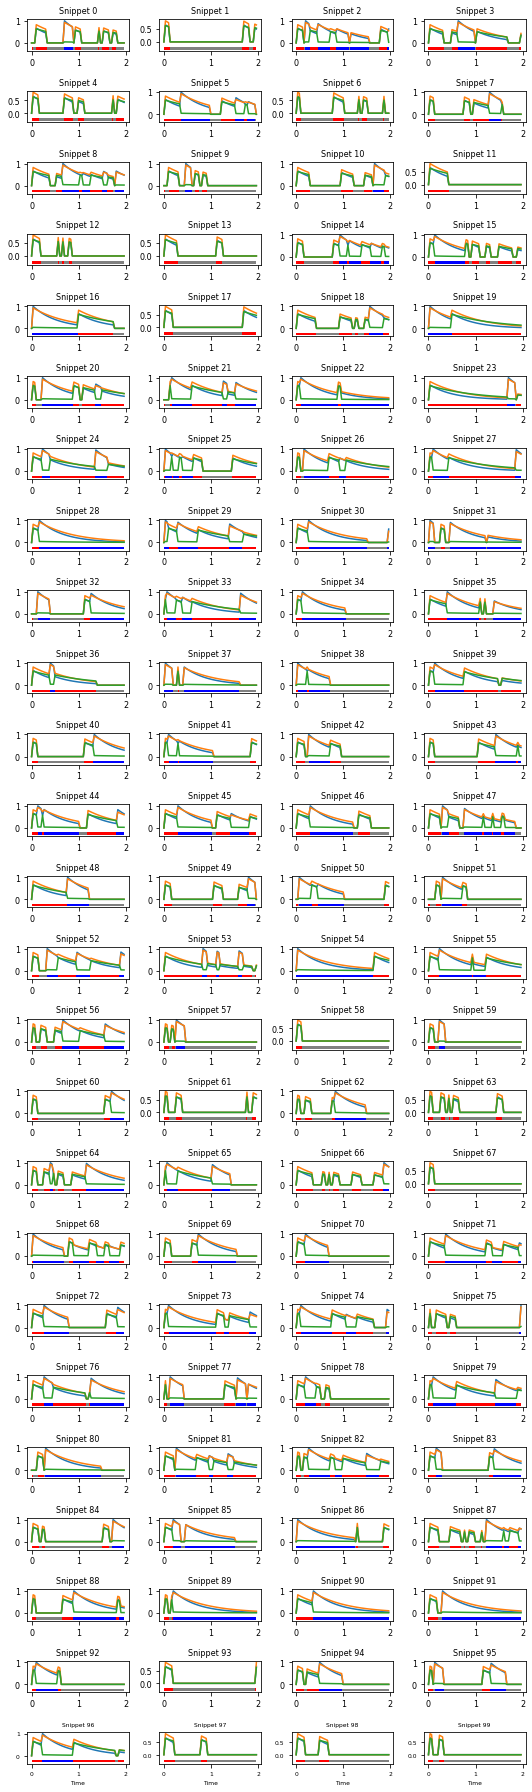

In [7]:
NSNP_PLOT = 100

rs_all_vs_all = [smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT)[:2] for i_s, i_p in list(zip(i_ss, i_ps))[:NSNP_PLOT]]
rs_all, vs_all = zip(*rs_all_vs_all)

fig, axs = plt.subplots(NSNP_PLOT//4, 4, figsize=(7.5, 1*NSNP_PLOT/4), tight_layout=True)
for csnp, (snp, vs, ax) in enumerate(zip(snps, vs_all, axs.flat)):
    plot_b(ax, t_snp, snp, [0, t_snp.max(), -.3, -.2], c=['gray', 'b', 'r'])
    ax.plot(t_snp, vs[:, :3])
    set_plot(ax, title=f'Snippet {csnp}', font_size=8)
    
for ax in axs[-1, :]:
    set_plot(ax, x_label='Time', font_size=6)

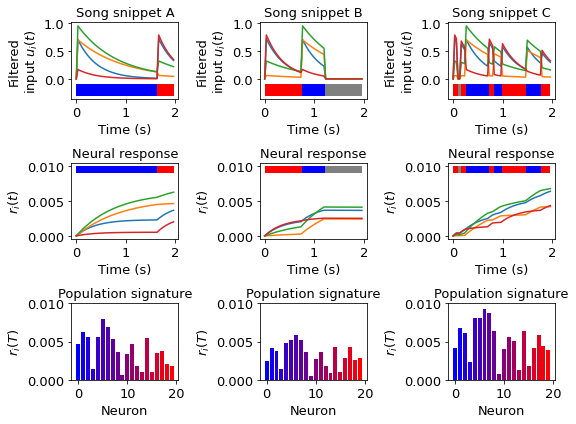

In [36]:
isnp_basis = [54, 48, 82]

inrn_plot = np.random.permutation(N)[:4]

basis = []
labels = 'ABC'

idx_sorted_tuning = np.argsort((np.abs(x_p) - np.abs(x_s))/(np.abs(x_s) + np.abs(x_p)))
colors_tuning = np.linspace([0, 0, 1], [1, 0, 0], N)

fig, axs = plt.subplots(3, 3, figsize=(8, 6), tight_layout=True)
for cisnp, (isnp, ax_col) in enumerate(zip(isnp_basis, axs.T)):
    snp = snps[isnp]
    i_s = i_ss[isnp]
    i_p = i_ps[isnp]
    
    rs, vs = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT)[:2]
    
    basis.append(rs[-1, :])
    
    plot_b(ax_col[0], t_snp, snp, [0, t_snp.max(), -.3, -.1], c=['gray', 'b', 'r'])
    ax_col[0].plot(t_snp, vs[:, inrn_plot])
    set_plot(ax_col[0], x_label='Time (s)', y_label='Filtered\ninput' + r' $u_i(t)$', title=f'Song snippet {labels[cisnp]}')
    
    # plot_b(ax_col[1], t_snp, snp, [0, t_snp.max(), -.3, -.2], c=['gray', 'b', 'r'])
    ax_col[1].plot(t_snp, rs[:, inrn_plot])
    plot_b(ax_col[1], t_snp, snp, [0, t_snp.max(), .009, .01], c=['gray', 'b', 'r'])
    set_plot(ax_col[1], x_label='Time (s)', y_label=r'$r_i(t)$', title='Neural response',)
    
    ax_col[2].bar(range(N), rs[-1, idx_sorted_tuning], color=colors_tuning)
    # for i in range(N):
    #     ax_col[2].bar([i], rs[-1, [i]])
    set_plot(ax_col[2], y_lim=(0, .01), x_label='Neuron', y_label=r'$r_i(T)$', title='Population signature', font_size=12)
    
for ax in axs.flat:
    set_plot(ax, font_size=13)
    
basis = np.transpose(basis)

fig.savefig('ms/fig_4_neural_signatures.svg')

In [37]:
# find readout weights
ALPHA = 1e-7
rgr = linear_model.Ridge(alpha=ALPHA, fit_intercept=False)
w = rgr.fit(basis.T, np.eye(3)).coef_.T

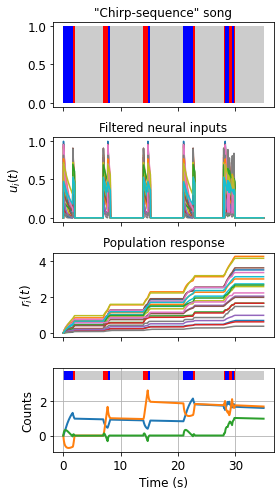

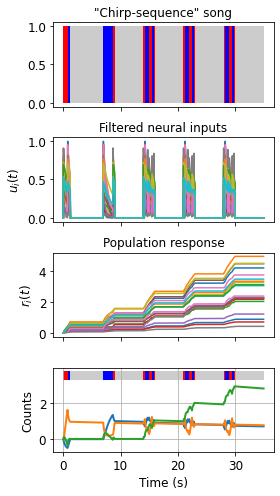

In [38]:
ichirps_all = [
    [0, 1, 1, 0, 2],
    [1, 0, 2, 2, 2],
]

NT_PAUSE = int(round(5/DT))

for cseq, ichirps in enumerate(ichirps_all):

    chirps = [snps[isnp_basis[ichirp]] for ichirp in ichirps]
    ct_starts = []
    ct_ends = []

    sng_segs = []

    for cchirp, chirp in enumerate(chirps):
        if cchirp == 0:
            ct_starts.append(0)
        else:
            ct_starts.append(len(cc(sng_segs)))
        sng_segs.append(chirp)
        ct_ends.append(len(cc(sng_segs)))
        sng_segs.append(np.zeros(NT_PAUSE))

    sng = cc(sng_segs)
    t_sng = np.arange(len(sng))*DT

    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)

    rs, vs = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT)[:2]

    fig, axs = plt.subplots(4, 1, figsize=(4, 7), tight_layout=True, sharex=True)
    # axs[0].plot(t_sng, vs[:, :2])
    plot_b(axs[0], t_sng, sng, [0, t_sng.max(), 0, 1], c=[(.8, .8, .8), 'b', 'r'])
    set_plot(axs[0], title='"Chirp-sequence" song')

    axs[1].plot(t_sng, vs)
    set_plot(axs[1], y_label=r'$u_i(t)$', title='Filtered neural inputs')

    axs[2].plot(t_sng, vs.cumsum(0)*DT)
    set_plot(axs[2], y_label=r'$r_i(t)$', title='Population response')

    plot_b(axs[3], t_sng, sng, [0, t_sng.max(), 3.25, 3.75], c=[(.8, .8, .8), 'b', 'r'])
    axs[3].plot(t_sng, rs@w, lw=2)
    axs[3].grid()
    set_plot(axs[3], x_label='Time (s)', y_label='Counts')

    fig.savefig(f'ms/fig_4_ev_accum_demo_{cseq}.svg')